In [1]:
import re
import json
import uuid
import glob
import pickle
import sys
import os
import math
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
from numpy import array
from pprint import pprint
import re
import scipy.stats as stat
from os.path import basename
import string
import pandas as pd
import numpy as np
import pyLDAvis
from empath import Empath
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer
from sklearn.model_selection import  cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from pycebox.ice import ice, ice_plot
import operator
from nltk import stem
from nltk.stem.snowball import *
from nltk.stem import PorterStemmer
import dask

# Enable logging for gensim - optional
import logging
logging.basicConfig(filename='lda_model_Parenting.log',format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

In [5]:
# setting up the styling for the plots in this notebook
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(40,60), "font.size":8,"axes.labelsize":10})
RANDOM_STATE = 420
N_JOBS=8

In [6]:
def empathize(text, category):
    return(lexicon.analyze(text, categories=[category], normalize=True))

In [7]:
def setting_training_test(dataframe, startdate, splitdate):
    #start_date = pd.datetime(startdate)
    ParentingAfter2012 = dataframe.loc[dataframe['created_utc'] > start_date]
    #separate the training and test data
    #split_date = pd.datetime(splitdate)
    df_training = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] <= split_date]
    df_test = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] > split_date]
    return df_training, df_test

In [8]:
def create_dad(dataframe):
    
    dataframe['DadBody']= dataframe.body.str.match('dad here|I am a dad|I\'m a dad|I am a father|father here|I\'m a father|I am a SAHD|I`m a SAHD|I was a SAHD|I am a stay-at-home father|I\'m a stay-at-home father|I was a stay-at-home father|I was a stay-at-home dad|I was a sahd')
    dataframe['DadAuthor'] = dataframe.author.str.contains('dad|daddy|dada|father', na=False)
    dataframe['Dad'] = dataframe.DadBody | dataframe.DadAuthor
    return dataframe

In [9]:
def create_mom(dataframe):
    
    dataframe['MomBody'] = dataframe.body.str.match('I\'m a mum|I am a mum|mum here|mom here|I am a mom|I\'m a mom|I am a mother|mother here|I\'m a mother| I am a stay-at-home mom|I\'m a stay-at-home mom|I was a stay-at-home mom|I was a sahm')
    dataframe['MomAuthor'] = dataframe.author.str.contains('mom|mother|mama|mum', na=False)
    dataframe['Mom'] = dataframe.MomBody | dataframe.MomAuthor
    return dataframe

In [10]:
def create_two_gender_df(dataframe):
    
    dataframe['Gendered'] = (dataframe.DadBody>0) | (dataframe.DadAuthor>0) | (dataframe.MomBody>0) | (dataframe.MomAuthor>0)
    
    return dataframe

In [11]:
def create_throwaway_df(dataframe):
    dataframe['body'] = dataframe['body'].str.lower()
    dataframe['author'] = dataframe['author'].str.lower()
    dataframe['ThrowAuth'] = dataframe.author.str.contains('thrw|throwaway|throw|thrw|thraway', na=False)

    dataframe['ThrowBody'] = dataframe.body.str.match('this is a throwaway|I am using a throwaway|I\'m using a throwawy')

    return dataframe

In [12]:
#Prepare the IV's from dataframe
#add throwaway variable
def prepare_data_for_models(dataframe):
    dataframe_piv = pd.pivot_table(dataframe, index= 'author', aggfunc= 'mean')
    #setting the users of more than one subreddit
    #for example, only r/Daddit and r/Mommit
    mask = dataframe_piv.Throwaway > 0
    dataframe_piv.loc[mask, 'Throwaway'] = 1
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway'].astype(int)
    dataframe_piv = dataframe_piv[dataframe_piv.index != '']
    return dataframe_piv

In [13]:
def calculate_tenure(dataframe):
    dataframe['created_utc'] = pd.to_datetime(dataframe['created_utc'],format='%Y%m%d', errors='ignore')
    gb = dataframe.groupby(['author', 'created_utc'])
    gr = dataframe.groupby(['author'], as_index = False)
    res = gr.agg({'created_utc':[min, max]})
    res.columns = ["".join(x) for x in res.columns.ravel()]
    res['tenure'] = res['created_utcmax'] - res['created_utcmin']
    res['tenure'] = res['tenure'].dt.days
    return res

In [14]:
def tfidf_topic(dataframe):
    corpus = dataframe.body.tolist()

    Processed_commands = Remove_Punct_Stem(corpus) 

    #texts = Processed_commands
    texts = Processed_commands
    #texts = '-'.join(documents)
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token]+=1

    tokenized = [[token for token in text if frequency[token]>1]for text in texts]

    wordfreq = {}
    for text in texts:
        for token in text:
            wordfreq[token]=frequency[token]  

    sorted_word = sorted(wordfreq.items(), key=operator.itemgetter(1))

    print(sorted_word[-10:])
    from gensim.models import TfidfModel
    from gensim.corpora import Dictionary
    dct = Dictionary(texts)
    corpus = [dct.doc2bow(line) for line in texts]
    model = TfidfModel(corpus)

    topWords = {}
    corpus_tfidf = model[corpus]
    for doc in corpus_tfidf:
        for iWord, tf_idf in doc:
            if iWord not in topWords:
                topWords[iWord] = 0

            if tf_idf > topWords[iWord]:
                topWords[iWord] = tf_idf

    wordimportance = []
    for i, item in enumerate(sorted(topWords.items(), key=lambda x: x[1], reverse=True), 1):
        wordimportance.append((dct[item[0]],item[1]))
        print("%2s: %-13s %s" % (i, dct[item[0]], item[1]))
        if i == 100: break
    return wordimportance, sorted_word

In [15]:
def Remove_Punct_Stem(documents):
    processed = []
    tokenizer = RegexpTokenizer(r'\w+')
    for document in documents:
        stop = stopwords.words('english')
        intermediate = [i for i in document if i not in stop]
        intermediate = tokenizer.tokenize(str(intermediate))
        # FIXME: using other stemmers also to know quality of each stemmed text
        lanste = LancasterStemmer()
        intermediate = [lanste.stem(i) for i in intermediate]
        processed.append(intermediate)
    return processed

In [16]:
def Preprocess(text):
    
    lower_text = []
            
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops and len(w)>=3]
    
    for line in text:
        lower_text.append(line.lower().split())
   
    text = " ".join(text)
    
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^A-Za-z0-9^\/+-=]", " ", text)
    text = re.sub(r"gt;", " ", text)
    text = re.sub(r"gt"," ", text)
    text = re.sub(r"&gt"," ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"!.,:"," ",text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"http://","",text)
    text = re.sub(r"www.","",text)
    text = re.sub(r"http\S+", "", text)

    
    ## Stemming
    text = text.split()
    #print(text[0])
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    #print(text[0])
    stemmed_tokenized_words = Tokinization(text)
    
    return stemmed_tokenized_words


In [17]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [18]:
def Tokinization(document):
    document = "".join(document)
    tokenizer = RegexpTokenizer(r'\w+')
    intermediate = tokenizer.tokenize(document)

    return intermediate

In [19]:
# The source for this is from here:
# https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
def get_p_values(model, X):
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    return p_values

In [20]:
# The source for this is from here:
# https://gist.github.com/lqdc/1ea1682ad1214956d95904ebde3134a5
def get_se(X, y, model):
    """StdErr per variable estimation.
    https://en.wikipedia.org/wiki/Ordinary_least_squares
    """
    MSE = np.mean((y - model.predict(X).T)**2)
    # numerically unstable below with openblas if rcond is less than that
    var_est = MSE * np.diag(np.linalg.pinv(np.dot(X.T, X), rcond=1e-10))
    SE_est = np.sqrt(var_est)
    return SE_est

def decision(coefs, X, intercept):
    return np.dot(X, coefs) + intercept

def get_probs(model, X, SE_est, z=1.96):
    """Estimate CI given data, StdErrors and model."""
    coefs = np.ravel(model.coef_)
    upper = coefs + (z * SE_est)
    lower = coefs - (z * SE_est)

    prob = 1. / (1. + np.exp(-decision(coefs, X, model.intercept_)))
    upper_prob = 1. / (1. + np.exp(-decision(upper, X, model.intercept_)))
    lower_prob = 1. / (1. + np.exp(-decision(lower, X, model.intercept_)))

    stacked = np.vstack((lower_prob, upper_prob))
    up = np.max(stacked, axis=0)
    lo = np.min(stacked, axis=0)
    return prob, upper, lower

def get_odd_ratio(model):
    return np.exp(model.coef_[0])

In [21]:
def plot_coefficients_old(classifier, feature_names, top_features=10):
    #cannot use sparse matrix with ravel()
    coef = classifier.coef_.toarray().ravel()
    print(coef)
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 10))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

In [22]:
def plot_coefficients(classifier, feature_names, top_features=20):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(len(classes)):


        print(classes[i])

        # Access the row containing the coefficients for this class
        class_coef = coef[i]


        # Below this, I have just replaced 'i' in your code with 'class_coef'
        # Pass this to get top and bottom features
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]

        # Concatenate the above two 
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        # create plot
        plt.figure(figsize=(10, 3))

        colors = ["red" if c < 0 else "blue" for c in class_coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), class_coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)

        # Here I corrected the start to 0 (Your code has 1, which shifted the labels)
        plt.xticks(np.arange(0, 1 + 2 * top_features), 
                   feature_names[top_coefficients], rotation=60, ha="right")
        plt.show()

In [23]:
def removeNone(intermediate):
    #remove None Values
    intermediate = ['' if v is None else v for v in intermediate]
    return intermediate

In [24]:
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)

In [25]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support


#The dataframe is not balanced and needs to be balanced 
#using SMOTE --> resample minority class
#using random undersampler --> resample majority class
def balance_dataset(dataframe, Features ,y_value):

    rus = RandomUnderSampler(random_state=0)  
    X_res, y_res = rus.fit_sample(dataframe[Features], dataframe[y_value])
    X_train_res, y_train_res, = X_res, y_res
    
    return X_train_res, y_train_res

#Normalize the values
#This is especially important when we added the variables:tenure, score etc.
#In this case, I am using the standard scaler in SKLearn
#This is a link to the description of the difference:
#http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
def Normalize_Dataset(X_train, X_test):

    X_train_res_norm = preprocessing.scale(X_train)
    X_test_norm = preprocessing.scale(X_test)
    
    return X_train_res_norm, X_test_norm

def logreg_model(X_train_res, y_train_res, X_test, y_test, Features):
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train_res, y_train_res)
    expected = y_test
    predicted = logisticRegr.predict(X_test)
    print(metrics.accuracy_score(expected, predicted))
    print(precision_recall_fscore_support(expected, predicted, average='binary'))
    print('AUC value is')
    roc=roc_auc_score(y_test, logisticRegr.predict_proba(X_test)[:,1])
    print(roc)
    p_values = get_p_values(logisticRegr, X_train_res)
    SE_est = get_se(X_train_res, y_train_res, logisticRegr)
    prob, up, lo = get_probs(logisticRegr,X_train_res, SE_est)
    OR = get_odd_ratio(logisticRegr)
    predict_score = list(zip(Features, logisticRegr.coef_[0], p_values,OR,up, lo))
    predict_score_sorted = sorted(predict_score, key=lambda tup: tup[2])
    predictions = pd.DataFrame(predict_score_sorted, columns=['predictor', 'importance','p-values','OR','up','low'])
    predictions = predictions.sort_values(['p-values'], ascending=False)
    sns.barplot(x="predictor", y="importance", data=predictions)
    plt.legend(loc=9)
    plt.rcParams['figure.figsize']=(50,20)
    plt.title('Logistic Regression Model Coeffiencts')
    plt.xticks(rotation='90')
    plt.ylabel('Coefficient', fontsize=30)
    plt.xlabel('Feature',fontsize=30)
    print(predict_score_sorted)
    return logisticRegr, predictions, p_values

# The source for this is from here:
# https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
def get_p_values(model, X):
    denom = (2.0*(1.0+np.cosh(model.decision_function(X))))
    F_ij = np.dot((X/denom[:,None]).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
    z_scores = model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
    return p_values

# The source for this is from here:
# https://gist.github.com/lqdc/1ea1682ad1214956d95904ebde3134a5
def get_se(X, y, model):
    """StdErr per variable estimation.
    https://en.wikipedia.org/wiki/Ordinary_least_squares
    """
    MSE = np.mean((y - model.predict(X).T)**2)
    # numerically unstable below with openblas if rcond is less than that
    var_est = MSE * np.diag(np.linalg.pinv(np.dot(X.T, X), rcond=1e-10))
    SE_est = np.sqrt(var_est)
    return SE_est

def decision(coefs, X, intercept):
    return np.dot(X, coefs) + intercept

def get_probs(model, X, SE_est, z=1.96):
    """Estimate CI given data, StdErrors and model."""
    coefs = np.ravel(model.coef_)
    upper = coefs + (z * SE_est)
    lower = coefs - (z * SE_est)

    prob = 1. / (1. + np.exp(-decision(coefs, X, model.intercept_)))
    upper_prob = 1. / (1. + np.exp(-decision(upper, X, model.intercept_)))
    lower_prob = 1. / (1. + np.exp(-decision(lower, X, model.intercept_)))

    stacked = np.vstack((lower_prob, upper_prob))
    up = np.max(stacked, axis=0)
    lo = np.min(stacked, axis=0)
    return prob, upper, lower

def get_odd_ratio(model):
    return np.exp(model.coef_[0])

def bayes_model(X_train_res, y_train_res, X_test, y_test, Features):
    model = GaussianNB()
    model.fit(X_train_res, y_train_res)
    print(model)
    expected = y_test
    predicted = model.predict(X_test)
    print(metrics.accuracy_score(expected, predicted))
    print(precision_recall_fscore_support(expected, predicted, average='binary'))
    print('AUC value is')
    roc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(roc)
    predict_score_NB = list(zip(Features, model.theta_[1]))
    predict_score_sorted_NB = sorted(predict_score_NB, key=lambda tup: tup[1])
    print(predict_score_sorted_NB)
    predictions_1 = pd.DataFrame(predict_score_sorted_NB, columns=['predictor', 'importance'])
    predictions_1 = predictions_1.sort_values(['importance'], ascending=False)
    predictions_1.plot(kind='bar', x='predictor', y='importance')
    predict_score_NB = list(zip(Features, model.theta_[0]))
    predict_score_sorted_NB = sorted(predict_score_NB, key=lambda tup: tup[1])
    print(predict_score_sorted_NB)
    predictions_2 = pd.DataFrame(predict_score_sorted_NB, columns=['predictor', 'importance'])
    predictions_2 = predictions_2.sort_values(['importance'], ascending=False)
    predictions_2.plot(kind='bar', x='predictor', y='importance')
    return model, predictions_1, predictions_2

def RandomForest_model(X_train_res, y_train_res, X_test, y_test, Features):
    # Random Forest Classifier
    model = RandomForestClassifier(warm_start=False, n_estimators=1000, min_samples_split=2, random_state=0, max_features="sqrt")
    model.fit(X_train_res, y_train_res)
    print(model)
    # make predictions
    expected = y_test
    predicted = model.predict(X_test)
    # summarize the fit of the model
    predict_cross_val = cross_val_predict(RandomForestClassifier(warm_start=False, n_estimators=1000, min_samples_split=2, random_state=123, max_features="log2"), X_train_res, y_train_res, cv=10)
    print('metrics using cross validation')
    print(metrics.accuracy_score(expected,predicted))
    print(precision_recall_fscore_support(expected, predicted, average='binary'))
    print('AUC value is')
    roc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    print(roc)
    predict_score_Decision_Tree = list(zip(Features, model.feature_importances_))
    predict_score_sorted_Decision_Tree = sorted(predict_score_Decision_Tree, key=lambda tup: tup[1])
    print(predict_score_sorted_Decision_Tree)
    predictions = pd.DataFrame(predict_score_sorted_Decision_Tree, columns=['predictor', 'importance'])
    predictions = predictions.sort_values(['importance'], ascending=False)
    predictions.plot(kind='bar', x='predictor', y='importance')
    return model, predictions

def SVM_linear_model(X_train_res, y_train_res, X_test, y_test, Feature_Names):
    # This is an SVM model with a linear kernel 
    model = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001, verbose=True)
    model.fit(X_train_res, y_train_res)
    print(model)
    # make predictions
    expected = y_test
    predicted = model.predict(X_test)
    # summarize the fit of the model
    print(metrics.accuracy_score(expected,predicted))
    print(precision_recall_fscore_support(expected, predicted, average='binary'))
    plot_coefficients(model, Feature_Names)
    return model

def setting_training_test(dataframe, startdate, splitdate):
    #start_date = pd.datetime(startdate)
    ParentingAfter2012 = dataframe.loc[dataframe['created_utc'] > start_date]
    #separate the training and test data
    #split_date = pd.datetime(splitdate)
    df_training = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] <= split_date]
    df_test = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] > split_date]
    return df_training, df_test

In [27]:
def logreg_model_CV(X_train_res, y_train_res, X_test, y_test, Features):
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression()
    scores = cross_val_score(logisticRegr, x_train, y_train, cv=10)
    logisticRegr.fit(X_train_res, y_train_res)
    expected = y_test
    predicted = logisticRegr.predict(X_test)
    print(metrics.accuracy_score(expected, predicted))
    print(precision_recall_fscore_support(expected, predicted, average='binary'))
    print('AUC value is')
    roc=roc_auc_score(y_test, logisticRegr.predict_proba(X_test)[:,1])
    print(roc)
    p_values = get_p_values(logisticRegr, X_train_res)
    SE_est = get_se(X_train_res, y_train_res, logisticRegr)
    prob, up, lo = get_probs(logisticRegr,X_train_res, SE_est)
    OR = get_odd_ratio(logisticRegr)
    predict_score = list(zip(Features, logisticRegr.coef_[0], p_values,OR,up, lo))
    predict_score_sorted = sorted(predict_score, key=lambda tup: tup[2])
    predictions = pd.DataFrame(predict_score_sorted, columns=['predictor', 'importance','p-values','OR','up','low'])
    predictions = predictions.sort_values(['p-values'], ascending=False)
    sns.barplot(x="predictor", y="importance", data=predictions)
    plt.legend(loc=9)
    plt.rcParams['figure.figsize']=(50,20)
    plt.title('Logistic Regression Model Coeffiencts')
    plt.xticks(rotation='90')
    plt.ylabel('Coefficient', fontsize=30)
    plt.xlabel('Feature',fontsize=30)
    print(predict_score_sorted)
    return logisticRegr, predictions, p_values

# LDA Test # 3

In [28]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import os

# Features

In [29]:
All_Sentiment_Features = ['score','tenure','WC', 'adverb', 'relativ', 'focuspresent', 'time', 'function', 'you',\
       'social', 'ppron', 'pronoun', 'verb', 'i', 'space', 'prep',\
       'affiliation', 'we', 'drives', 'home', 'article', 'bio', 'body',\
       'motion', 'number', 'percept', 'adj', 'see', 'money', 'death', 'power',\
       'work', 'ipron', 'informal', 'assent', 'interrog', 'auxverb', 'cause',\
       'cogproc', 'tentat', 'compare', 'quant', 'affect', 'posemo', 'leisure',\
       'conj', 'differ', 'negate', 'insight', 'they', 'focusfuture', 'reward',\
       'focuspast', 'negemo', 'health', 'achieve', 'feel', 'family', 'female',\
       'sad', 'risk', 'shehe', 'male', 'discrep', 'certain', 'hear', 'nonflu',\
       'netspeak', 'anx', 'ingest', 'friend', 'filler', 'anger', 'sexual',\
       'swear', 'relig']

In [30]:
All_Sentiment_Prop = ['Throwaway','author','created_utc','score','WC', 'adverb', 'relativ', 'focuspresent', 'time', 'function', 'you',\
       'social', 'ppron', 'pronoun', 'verb', 'i', 'space', 'prep',\
       'affiliation', 'we', 'drives', 'home', 'article', 'bio', 'body',\
       'motion', 'number', 'percept', 'adj', 'see', 'money', 'death', 'power',\
       'work', 'ipron', 'informal', 'assent', 'interrog', 'auxverb', 'cause',\
       'cogproc', 'tentat', 'compare', 'quant', 'affect', 'posemo', 'leisure',\
       'conj', 'differ', 'negate', 'insight', 'they', 'focusfuture', 'reward',\
       'focuspast', 'negemo', 'health', 'achieve', 'feel', 'family', 'female',\
       'sad', 'risk', 'shehe', 'male', 'discrep', 'certain', 'hear', 'nonflu',\
       'netspeak', 'anx', 'ingest', 'friend', 'filler', 'anger', 'sexual',\
       'swear', 'relig']

In [31]:
All_LDA_Features = ['score','tenure', 'WC','Picky_Eaters', 'Sleep_Training', 'Nursing', 'Dad_Support',\
       'Parenting_Jokes', 'Smoke_Drugs_Alcohol', \
       'College', 'Grandparents', 'Naked_Privacy', 'Allergy_Sick_Runny_Nose',\
       'Child_Food', 'Parenting_Groups_Religious', 'Father_Role',\
       'Toys_Playing', 'Diapers', 'After_First_Child',\
       'Child_Activity', 'Baby_Gear', 'Psych_Stress', 'Parent_Gear',\
       'Child_Autonomy_Str_Danger', 'Circumcision', 'Hair_Care', 'Vaccines',\
       'Teen_Changes', 'BabyProof_Accidents', 'Swimming', 'Moderator',\
       'School', 'Male_Norms', 'Birth', 'Joke', 'Dogs', 'Diagnosing_Disorders',\
       'Cost_Financial_Planning','Children_Socializing', 'Santa', 'Work_Parenting_Schedule',\
       'Religious_Social_Beleifs', 'CPS_Child_Abuse', 'Bathtime_Sleep_Routine',\
       'Media', 'Tantrum_Mngmnt_Discipline','Puppy', \
       'Parenting_Pregnany_Hardships_Experiences', 'Potty_Training',\
       'Language_Reading', 'Music', 'Edu_Phil', 'Congrats',\
       'Challenging_Behavior', 'Managing_Grief_Unexpected_Pregnancy',\
       'Doors_Child Accidents','Family_Car', 'Bully',\
       'Thanks_Support', 'Parenting_Nature', 'Skin_Care_Cloth',\
       'Child_Support_CPS']

In [32]:
All_LDA_Prop = ['Picky_Eaters', 'Sleep_Training', 'Nursing', 'Dad_Support',\
       'Parenting_Jokes', 'Smoke_Drugs_Alcohol', \
       'College', 'Grandparents', 'Naked_Privacy', 'Allergy_Sick_Runny_Nose',\
       'Child_Food', 'Parenting_Groups_Religious', 'Father_Role',\
       'Toys_Playing', 'Diapers', 'After_First_Child',\
       'Child_Activity', 'Baby_Gear', 'Psych_Stress', 'Parent_Gear',\
       'Child_Autonomy_Str_Danger', 'Circumcision', 'Hair_Care', 'Vaccines',\
       'Teen_Changes', 'BabyProof_Accidents', 'Swimming', 'Moderator',\
       'School', 'Male_Norms', 'Birth', 'Joke', 'Dogs', 'Diagnosing_Disorders',\
       'Cost_Financial_Planning','Children_Socializing', 'Santa', 'Work_Parenting_Schedule',\
       'Religious_Social_Beleifs', 'CPS_Child_Abuse', 'Bathtime_Sleep_Routine',\
       'Media', 'Tantrum_Mngmnt_Discipline','Puppy', \
       'Parenting_Pregnany_Hardships_Experiences', 'Potty_Training',\
       'Language_Reading', 'Music', 'Edu_Phil', 'Congrats',\
       'Challenging_Behavior', 'Managing_Grief_Unexpected_Pregnancy',\
       'Doors_Child Accidents','Family_Car', 'Bully',\
       'Thanks_Support', 'Parenting_Nature', 'Skin_Care_Cloth',\
       'Child_Support_CPS']

In [33]:
All_LDA_Prop_PSM = ['name','link_id','parent_id','Picky_Eaters', 'Sleep_Training', 'Nursing', 'Dad_Support',\
       'Parenting_Jokes', 'Smoke_Drugs_Alcohol', \
       'College', 'Grandparents', 'Naked_Privacy', 'Allergy_Sick_Runny_Nose',\
       'Child_Food', 'Parenting_Groups_Religious', 'Father_Role',\
       'Toys_Playing', 'Diapers', 'After_First_Child',\
       'Child_Activity', 'Baby_Gear', 'Psych_Stress', 'Parent_Gear',\
       'Child_Autonomy_Str_Danger', 'Circumcision', 'Hair_Care', 'Vaccines',\
       'Teen_Changes', 'BabyProof_Accidents', 'Swimming', 'Moderator',\
       'School', 'Male_Norms', 'Birth', 'Joke', 'Dogs', 'Diagnosing_Disorders',\
       'Cost_Financial_Planning','Children_Socializing', 'Santa', 'Work_Parenting_Schedule',\
       'Religious_Social_Beleifs', 'CPS_Child_Abuse', 'Bathtime_Sleep_Routine',\
       'Media', 'Tantrum_Mngmnt_Discipline','Puppy', \
       'Parenting_Pregnany_Hardships_Experiences', 'Potty_Training',\
       'Language_Reading', 'Music', 'Edu_Phil', 'Congrats',\
       'Challenging_Behavior', 'Managing_Grief_Unexpected_Pregnancy',\
       'Doors_Child Accidents','Family_Car', 'Bully',\
       'Thanks_Support', 'Parenting_Nature', 'Skin_Care_Cloth',\
       'Child_Support_CPS']

In [169]:
All_Features = ['score', 'tenure','WC', 'adverb', 'relativ', 'focuspresent', 'time', 'function', 'you',\
       'social', 'ppron', 'pronoun', 'verb', 'i', 'space', 'prep',\
       'affiliation', 'we', 'drives', 'home', 'article', 'bio', 'body',\
       'motion', 'number', 'percept', 'adj', 'see', 'money', 'death', 'power',\
       'work', 'ipron', 'informal', 'assent', 'interrog', 'auxverb', 'cause',\
       'cogproc', 'tentat', 'compare', 'quant', 'affect', 'posemo', 'leisure',\
       'conj', 'differ', 'negate', 'insight', 'they', 'focusfuture', 'reward',\
       'focuspast', 'negemo', 'health', 'achieve', 'feel', 'family', 'female',\
       'sad', 'risk', 'shehe', 'male', 'discrep', 'certain', 'hear', 'nonflu',\
       'netspeak', 'anx', 'ingest', 'friend', 'filler', 'anger', 'sexual',\
       'swear', 'relig','Picky_Eaters', 'Sleep_Training', 'Nursing', 'Dad_Support',\
       'Parenting_Jokes', 'Smoke_Drugs_Alcohol', \
       'College', 'Grandparents', 'Naked_Privacy', 'Allergy_Sick_Runny_Nose',\
       'Child_Food', 'Parenting_Groups_Religious', 'Father_Role',\
       'Toys_Playing', 'Diapers', 'After_First_Child',\
       'Child_Activity', 'Baby_Gear', 'Psych_Stress', 'Parent_Gear',\
       'Child_Autonomy_Str_Danger', 'Circumcision', 'Hair_Care', 'Vaccines',\
       'Teen_Changes', 'BabyProof_Accidents', 'Swimming', 'Moderator',\
       'School', 'Male_Norms', 'Birth', 'Joke', 'Dogs', 'Diagnosing_Disorders',\
       'Cost_Financial_Planning','Children_Socializing', 'Santa', 'Work_Parenting_Schedule',\
       'Religious_Social_Beleifs', 'CPS_Child_Abuse', 'Bathtime_Sleep_Routine',\
       'Media', 'Tantrum_Mngmnt_Discipline','Puppy', \
       'Parenting_Pregnany_Hardships_Experiences', 'Potty_Training',\
       'Language_Reading', 'Music', 'Edu_Phil', 'Congrats',\
       'Challenging_Behavior', 'Managing_Grief_Unexpected_Pregnancy',\
       'Doors_Child Accidents','Family_Car', 'Bully',\
       'Thanks_Support', 'Parenting_Nature', 'Skin_Care_Cloth',\
       'Child_Support_CPS']

# Classifier - time only

In [60]:
Mizo_All = pd.read_pickle('Parenting_Complete_Sentiment_LDA.pkl')

In [61]:
Mizo_Sum = pd.pivot_table(Mizo_All, index= 'author', aggfunc= 'sum')

In [114]:
numcomments = Mizo_All.author.value_counts()

In [115]:
numcomments_df = pd.DataFrame(numcomments)

In [116]:
numcomments_df = numcomments_df.rename(columns={'author': 'num_comments'})

In [117]:
numcomments_df.index.names = ['author']

In [118]:
Mizo_All_Pivot_numComments = pd.merge(Mizo_All_pivoted, numcomments_df, on="author")

In [119]:
Mizo_All_Pivot_numComments.head()

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,tenure,they,time,verb,we,work,you,num_comments
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------FTFY,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.406521,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.090138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343455,0.000000,0.132916,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,100.0,0.0,2.0,1.50,6.0,5.0,1.00,1.5,0.0,4.0,0.0,7.00,1.5,0.5,1.50,1.0,8.0,0.00,6.0,0.0,1.50,0.0,5.00,0.50,1.0,0.5,0.0,0.0,10.0,8.50,0.0,47.00,1.0,3.0,0.00,5.50,5.0,0.0,3.0,1.0,6.0,1.0,0.5,1.50,1.0,1.0,3.50,5.0,0.0,1.00,4.50,1.00,1.00,10.0,11.5,16.0,1.0,9.0,0.0,1.00,1.0,0.50,11.00,0.50,0.0,1.0,14.50,3.5,0.0,1.5,0,1.0,3.50,15.5,0.0,4.0,2.50,2
------me,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.802698,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,10.0,0.0,0.0,0.00,1.0,0.0,0.00,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,3.0,0.00,0.0,0.0,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6.00,0.0,0.0,0.00,1.00,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,1.0,1.0,3.0,1.0,1.0,0.0,0.00,0.0,0.00,2.00,0.00,0.0,0.0,0.00,0.0,0.0,1.0,0,0.0,1.00,1.0,0.0,0.0,0.00,1
-----iMartijn-----,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.647002,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,29.0,0.0,0.0,1.00,5.0,1.0,0.00,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,2.0,1.00,3.0,0.0,0.00,0.0,1.00,2.00,0.0,1.0,0.0,0.0,0.0,3.00,0.0,14.00,0.0,0.0,0.00,1.00,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.00,1.0,1.0,0.00,0.0,0.0,0.00,0.00,1.00,1.00,2.0,3.0,4.0,1.0,4.0,0.0,0.00,0.0,0.00,7.00,0.00,0.0,0.0,5.00,1.0,0.0,1.0,0,1.0,2.00,3.0,0.0,0.0,0.00,1
-----username-----,0.0,0.0,0.093582,0.000000,0.0,0.191683,0.0,0.0,0.0,0.0,0.0,0.000000,0.154482,0.0,0.05022,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048615,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.068531,0.0,0.0,0.0,0.0,0.0,0,0.314393,0.0,31.0,0.0,0.5,2.25,1.5,1.0,1.25,0.0,0.0,2.0,0.0,1.25,0.5,0.0,1.25,0.5,3.0,0.75,3.0,0.0,0.75,0.0,2.75,1.25,0.0,1.5,0.0,0.0,1.5,2.25,0.0,15.25,0.5,

In [120]:
Mizo_Sum = Mizo_All_Pivot_numComments[['num_comments']]

In [121]:
Mizo_Sum

,num_comments
author,
----------FTFY,2
------me,1
-----iMartijn-----,1
-----username-----,4
----_____----,2
---Bokonon---,4
---DAD---,21
---annon---,144
---sniff---,1


In [69]:
Mizo_All_Pivot_numComments['score_comment'] = Mizo_All_Pivot_numComments['score']/Mizo_All_Pivot_numComments['num_comments']

In [198]:
Mizo_Sum.to_pickle('Score_Sum_Author.pickle')

In [196]:
Mizo_All_Pivot_numComments_score_sum = pd.merge(Mizo_All_Pivot_numComments, Mizo_Sum, on="author")

In [72]:
tenure_Feature= ['tenure']

In [84]:
start_date = pd.datetime(2012,1,1)
split_date = pd.datetime(2018,1,1)

df_training_before, df_test_before = setting_training_test(Mizo_All, startdate=start_date, splitdate=split_date )

In [85]:
df_training = prepare_data_for_models(df_training_before)
df_test = prepare_data_for_models(df_test_before)

In [86]:
tenure = calculate_tenure(Mizo_All)

In [87]:
df_training = pd.merge(df_training, tenure, on="author")
df_test = pd.merge(df_test, tenure, on="author")

In [88]:
df_training =  df_training.fillna(0)
df_test =  df_test.fillna(0)

In [89]:
X_train_res, y_train_res =  balance_dataset(df_training, Features=tenure_Feature, y_value='Throwaway')
X_test,  y_test = balance_dataset(df_test, Features=tenure_Feature , y_value='Throwaway')

In [90]:
df_training.head()

,author,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,they,time,verb,we,work,you,created_utcmin,created_utcmax,tenure
0,----------FTFY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406521,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.090138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343455,0.000000,0.132916,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,100.000000,0.000000,2.000000,1.500000,6.000000,5.000000,1.000000,1.50000,0.00000,4.000000,0.000000,7.000000,1.500000,0.50000,1.500000,1.000000,8.000000,0.000000,6.000000,0.000000,1.50000,0.00000,5.000000,0.500000,1.000000,0.500000,0.000000,0.000000,10.000000,8.500000,0.000000,47.000000,1.000000,3.000000,0.000000,5.500000,5.000000,0.000000,3.000000,1.000000,6.000000,1.00000,0.500000,1.500000,1.000000,1.00000,3.500000,5.000000,0.000000,1.000000,4.500000,1.000000,1.000000,10.000000,11.50000,16.000000,1.000000,9.000000,0.000000,1.000000,1.000000,0.500000,11.000000,0.500000,0.000000,1.000000,14.500000,3.500000,0.000000,1.500000,1.000000,3.500000,15.500000,0.000000,4.000000,2.500000,2015-12-12 04:52:56,2015-12-12 21:14:02,0
1,----_____----,0.000000,0.000000,0.000000,0.192439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.417825,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.267060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,21.000000,0.000000,0.000000,0.500000,1.000000,2.500000,1.000000,0.00000,0.00000,0.500000,0.000000,2.000000,0.500000,0.00000,0.500000,0.000000,1.000000,0.500000,2.000000,0.000000,0.00000,0.00000,2.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.500000,0.500000,2.500000,0.000000,2.500000,2.50000,3.500000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,27.000000,0.500000,0.000000,0.500000,3.500000,0.000000,0.000000,0.500000,0.000000,1.000000,3.500000,0.500000,0.000000,1.000000,2017-07-13 00:36:15,2017-10-25 20:34:55,104
2,---Bokonon---,0.000000,0.000000,0.000000

In [91]:
len(y_train_res)

2262

In [92]:
len(X_train_res)

2262

In [93]:
X_train_res, X_test_res = Normalize_Dataset(X_train_res,X_test)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [94]:
len(X_train_res)

2262

In [95]:
len(y_train_res)

2262

0.679640718563
(0.62345679012345678, 0.90718562874251496, 0.73902439024390232, None)
AUC value is
0.742358098175
[('tenure', -1.2990182045903744, 1.5149005134418156e-49, 0.27279949489011351, -1.2752725886506329, -1.322763820530116)]


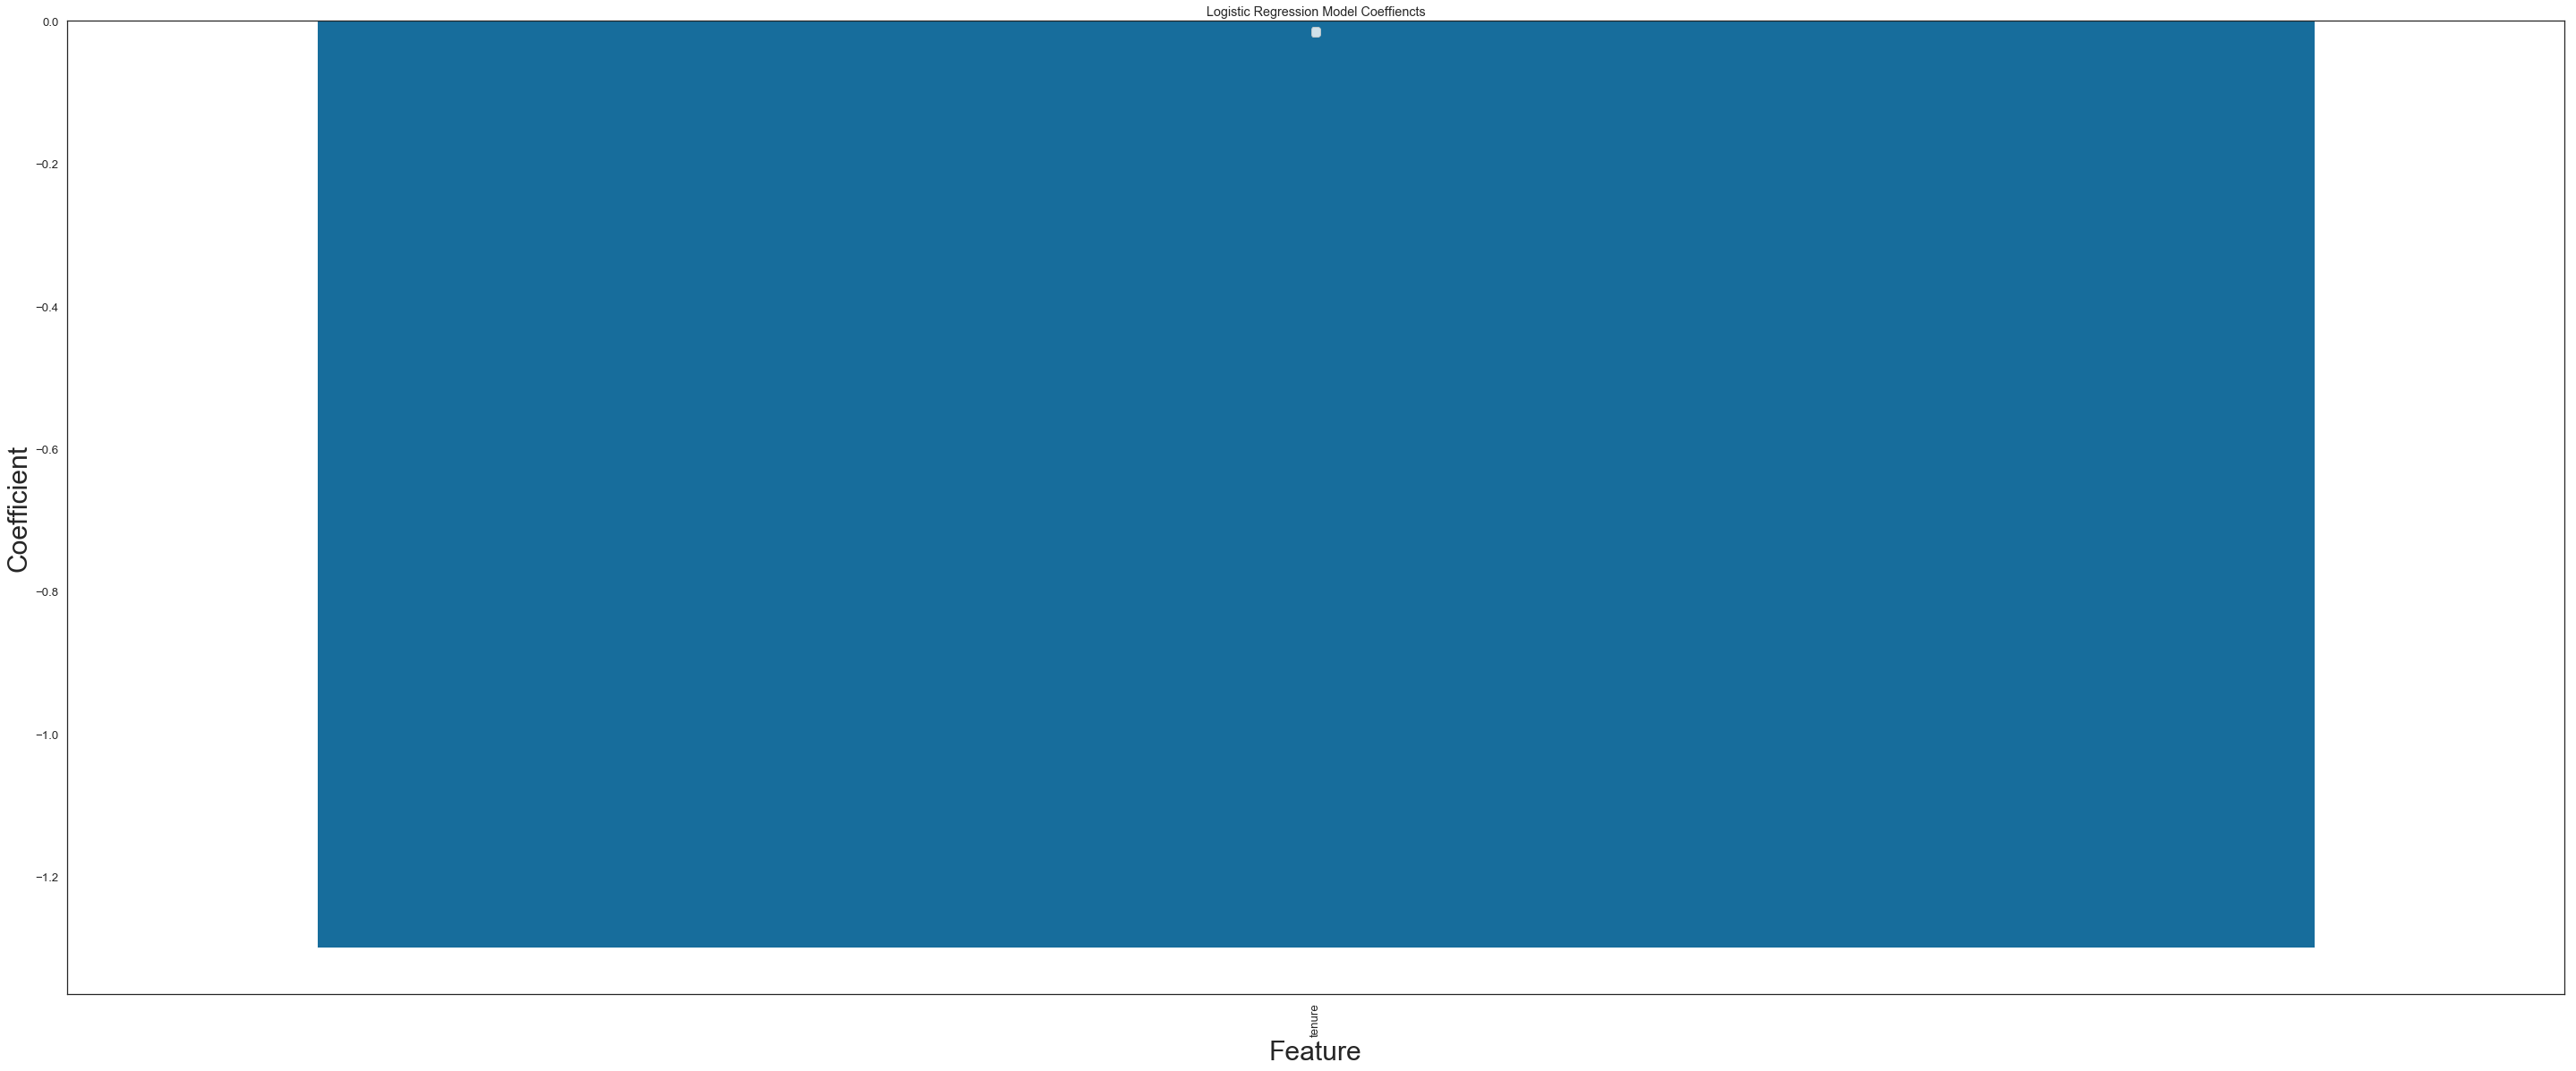

In [96]:
LDAplusthrlogmodel, LDAplusthrlogpredict, p_values = logreg_model(X_train_res=X_train_res, y_train_res=y_train_res, X_test=X_test_res, y_test=y_test, Features=tenure_Feature)

# Classifier - Random

In [164]:
Mizo_All_tenured = pd.read_pickle('Mizo_All_Tenured_Before_Pivoting.pkl')

In [165]:
Mizo_All_pivoted = prepare_data_for_models(Mizo_All_tenured)

In [167]:
Mizo_All_pivoted

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,tenure,they,time,verb,we,work,you
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------FTFY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343455,0.000000,0.132916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,100.000000,0.000000,2.000000,1.500000,6.000000,5.000000,1.000000,1.500000,0.000000,4.000000,0.000000,7.000000,1.500000,0.500000,1.500000,1.000000,8.000000,0.000000,6.000000,0.000000,1.500000,0.000000,5.000000,0.500000,1.000000,0.500000,0.000000,0.000000,10.000000,8.500000,0.000000,47.000000,1.000000,3.000000,0.000000,5.500000,5.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.500000,1.500000,1.000000,1.000000,3.500000,5.000000,0.000000,1.000000,4.500000,1.000000,1.000000,10.000000,11.500000,16.000000,1.000000,9.000000,0.000000,1.000000,1.000000,0.500000,11.000000,0.500000,0.000000,1.000000,14.500000,3.500000,0.000000,1.500000,0,1.000000,3.500000,15.500000,0.000000,4.000000,2.500000
------me,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
-----

In [170]:
X_train, X_test, y_train, y_test = train_test_split(Mizo_All_pivoted[All_Features], Mizo_All_pivoted['Throwaway'], test_size=0.20, random_state=42)

In [171]:
X_test

,score,tenure,WC,adverb,relativ,focuspresent,time,function,you,social,ppron,pronoun,verb,i,space,prep,affiliation,we,drives,home,article,bio,body,motion,number,percept,adj,see,money,death,power,work,ipron,informal,assent,interrog,auxverb,cause,cogproc,tentat,compare,quant,affect,posemo,leisure,conj,differ,negate,insight,they,focusfuture,reward,focuspast,negemo,health,achieve,feel,family,female,sad,risk,shehe,male,discrep,certain,hear,nonflu,netspeak,anx,ingest,friend,filler,anger,sexual,swear,relig,Picky_Eaters,Sleep_Training,Nursing,Dad_Support,Parenting_Jokes,Smoke_Drugs_Alcohol,College,Grandparents,Naked_Privacy,Allergy_Sick_Runny_Nose,Child_Food,Parenting_Groups_Religious,Father_Role,Toys_Playing,Diapers,After_First_Child,Child_Activity,Baby_Gear,Psych_Stress,Parent_Gear,Child_Autonomy_Str_Danger,Circumcision,Hair_Care,Vaccines,Teen_Changes,BabyProof_Accidents,Swimming,Moderator,School,Male_Norms,Birth,Joke,Dogs,Diagnosing_Disorders,Cost_Financial_Planning,Children_Socializing,Santa,Work_Parenting_Schedule,Religious_Social_Beleifs,CPS_Child_Abuse,Bathtime_Sleep_Routine,Media,Tantrum_Mngmnt_Discipline,Puppy,Parenting_Pregnany_Hardships_Experiences,Potty_Training,Language_Reading,Music,Edu_Phil,Congrats,Challenging_Behavior,Managing_Grief_Unexpected_Pregnancy,Doors_Child Accidents,Family_Car,Bully,Thanks_Support,Parenting_Nature,Skin_Care_Cloth,Child_Support_CPS
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MetaphysicalStiff,12.000000,31,72.500000,5.000000,9.500000,3.000000,3.000000,46.500000,0.500000,10.000000,11.000000,18.500000,12.000000,6.000000,5.000000,11.000000,2.000000,1.000000,6.000000,0.500000,4.000000,1.500000,0.000000,1.500000,0.500000,3.500000,3.000000,0.500000,0.000000,0.000000,3.000000,1.000000,7.500000,1.000000,1.000000,2.000000,5.500000,1.500000,9.500000,1.500000,3.000000,0.500000,4.500000,3.000000,0.500000,7.500000,2.000000,0.000000,2.000000,0.000000,0.500000,0.500000,5.000000,1.500000,0.500000,0.000000,1.500000,1.000000,4.000000,1.000000,0.500000,3.500000,0.500000,3.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.440491,0.000000,0.000000,0.000000,0.000000,0.073464,0.000000,0.000000,0.000000,0.000000,0.050674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hanlon,7.857143,456,47.428571,2.428571,4.714286,4.000000,2.571429,25.714286,0.857143,5.571429,5.428571,8.714286,9.000000,2.285714,1.714286,6.000000,1.857143,1.142857,4.000000,0.000000,2.857143,0.285714,0.000000,0.571429,0.571429,1.428571,2.000000,1.142857,0.571429,0.000000,0.571429,0.714286,3.285714,0.428571,0.428571,0.714286,3.857143,1.142857,6.714286,1.142857,1.428571,1.000000,2.714286,1.571429,0.000000,3.000000,2.000000,0.428571,1.571429,0.571429,0.285714,1.142857,3.428571,1.000000,0.142857,0.428571,0.000000,0.571429,0.142857,0.000000,0.142857,0.571429,0.571429,1.428571,0.714286,0.285714,0.142857,0.000000,0.428571,0.142857,0.285714,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060769,0.027736,0.000000,0.000000,0.021277,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091273,0.070520,0.000000,0.132798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107205
ibcreative,2.0000

In [172]:
rus = RandomUnderSampler(random_state=0)  
X_res, y_res = rus.fit_sample(X_train, y_train)
X_train_res, y_train_res, = X_res, y_res

In [173]:
X_train_res

array([[  2.94915254e+00,   9.03000000e+02,   4.38983051e+01, ...,
          3.78003014e-02,   1.07305532e-02,   1.27717630e-02],
       [  3.00000000e+00,   0.00000000e+00,   6.57000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.20000000e+00,   1.06200000e+03,   9.44000000e+01, ...,
          2.85714287e-03,   2.85714287e-03,   2.85714287e-03],
       ..., 
       [  1.75000000e+00,   0.00000000e+00,   3.06750000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.47619048e+00,   0.00000000e+00,   7.73333333e+01, ...,
          0.00000000e+00,   0.00000000e+00,   1.40925007e-02],
       [  3.00000000e+00,   0.00000000e+00,   2.33000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [174]:
rus = RandomUnderSampler(random_state=0)  
X_test, y_test = rus.fit_sample(X_test, y_test)
X_test_res, y_test_res, = X_test, y_test

In [175]:
X_test_res

array([[  6.50000000e+00,   5.35000000e+02,   3.20000000e+01, ...,
          0.00000000e+00,   4.00738418e-01,   0.00000000e+00],
       [  2.00000000e+00,   1.00000000e+01,   5.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  7.66666667e+00,   1.12400000e+03,   2.25000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   5.68664372e-02],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.50000000e+00,   0.00000000e+00,   1.17000000e+02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.66666667e+00,   0.00000000e+00,   5.86666667e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

0.731861198738
(0.73186119873817035, 0.73186119873817035, 0.73186119873817024, None)
AUC value is
0.79396749893


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt


[('tenure', -0.0021954030424897976, 1.5215564329386e-21, 0.99780700509217191, -0.0021464641916141688, -0.0022443418933654263), ('conj', -0.25232902125332812, 0.00012389451165990045, 0.77698905009677921, -0.22953936018438376, -0.27511868232227249), ('focuspast', -0.18328160317387954, 0.0013523089554268329, 0.83253367859763239, -0.16410138701847071, -0.20246181932928836), ('auxverb', -0.25058252853496821, 0.0021951544169030546, 0.77834724150548751, -0.22179085748832755, -0.27937419958160886), ('function', 0.19388792964810361, 0.0066159957334711609, 1.2139602263826625, 0.21872464297211258, 0.16905121632409464), ('health', 0.46714414078570737, 0.010968642581736457, 1.5954313535728504, 0.52460999695543165, 0.4096782846159831), ('article', -0.20568256579780483, 0.011334556866831352, 0.8140914557432799, -0.17710627559270481, -0.23425885600290486), ('insight', 0.25106894614631087, 0.01143344802218226, 1.2853987045633011, 0.28501806301590127, 0.21711982927672047), ('verb', 0.13808417996103545, 

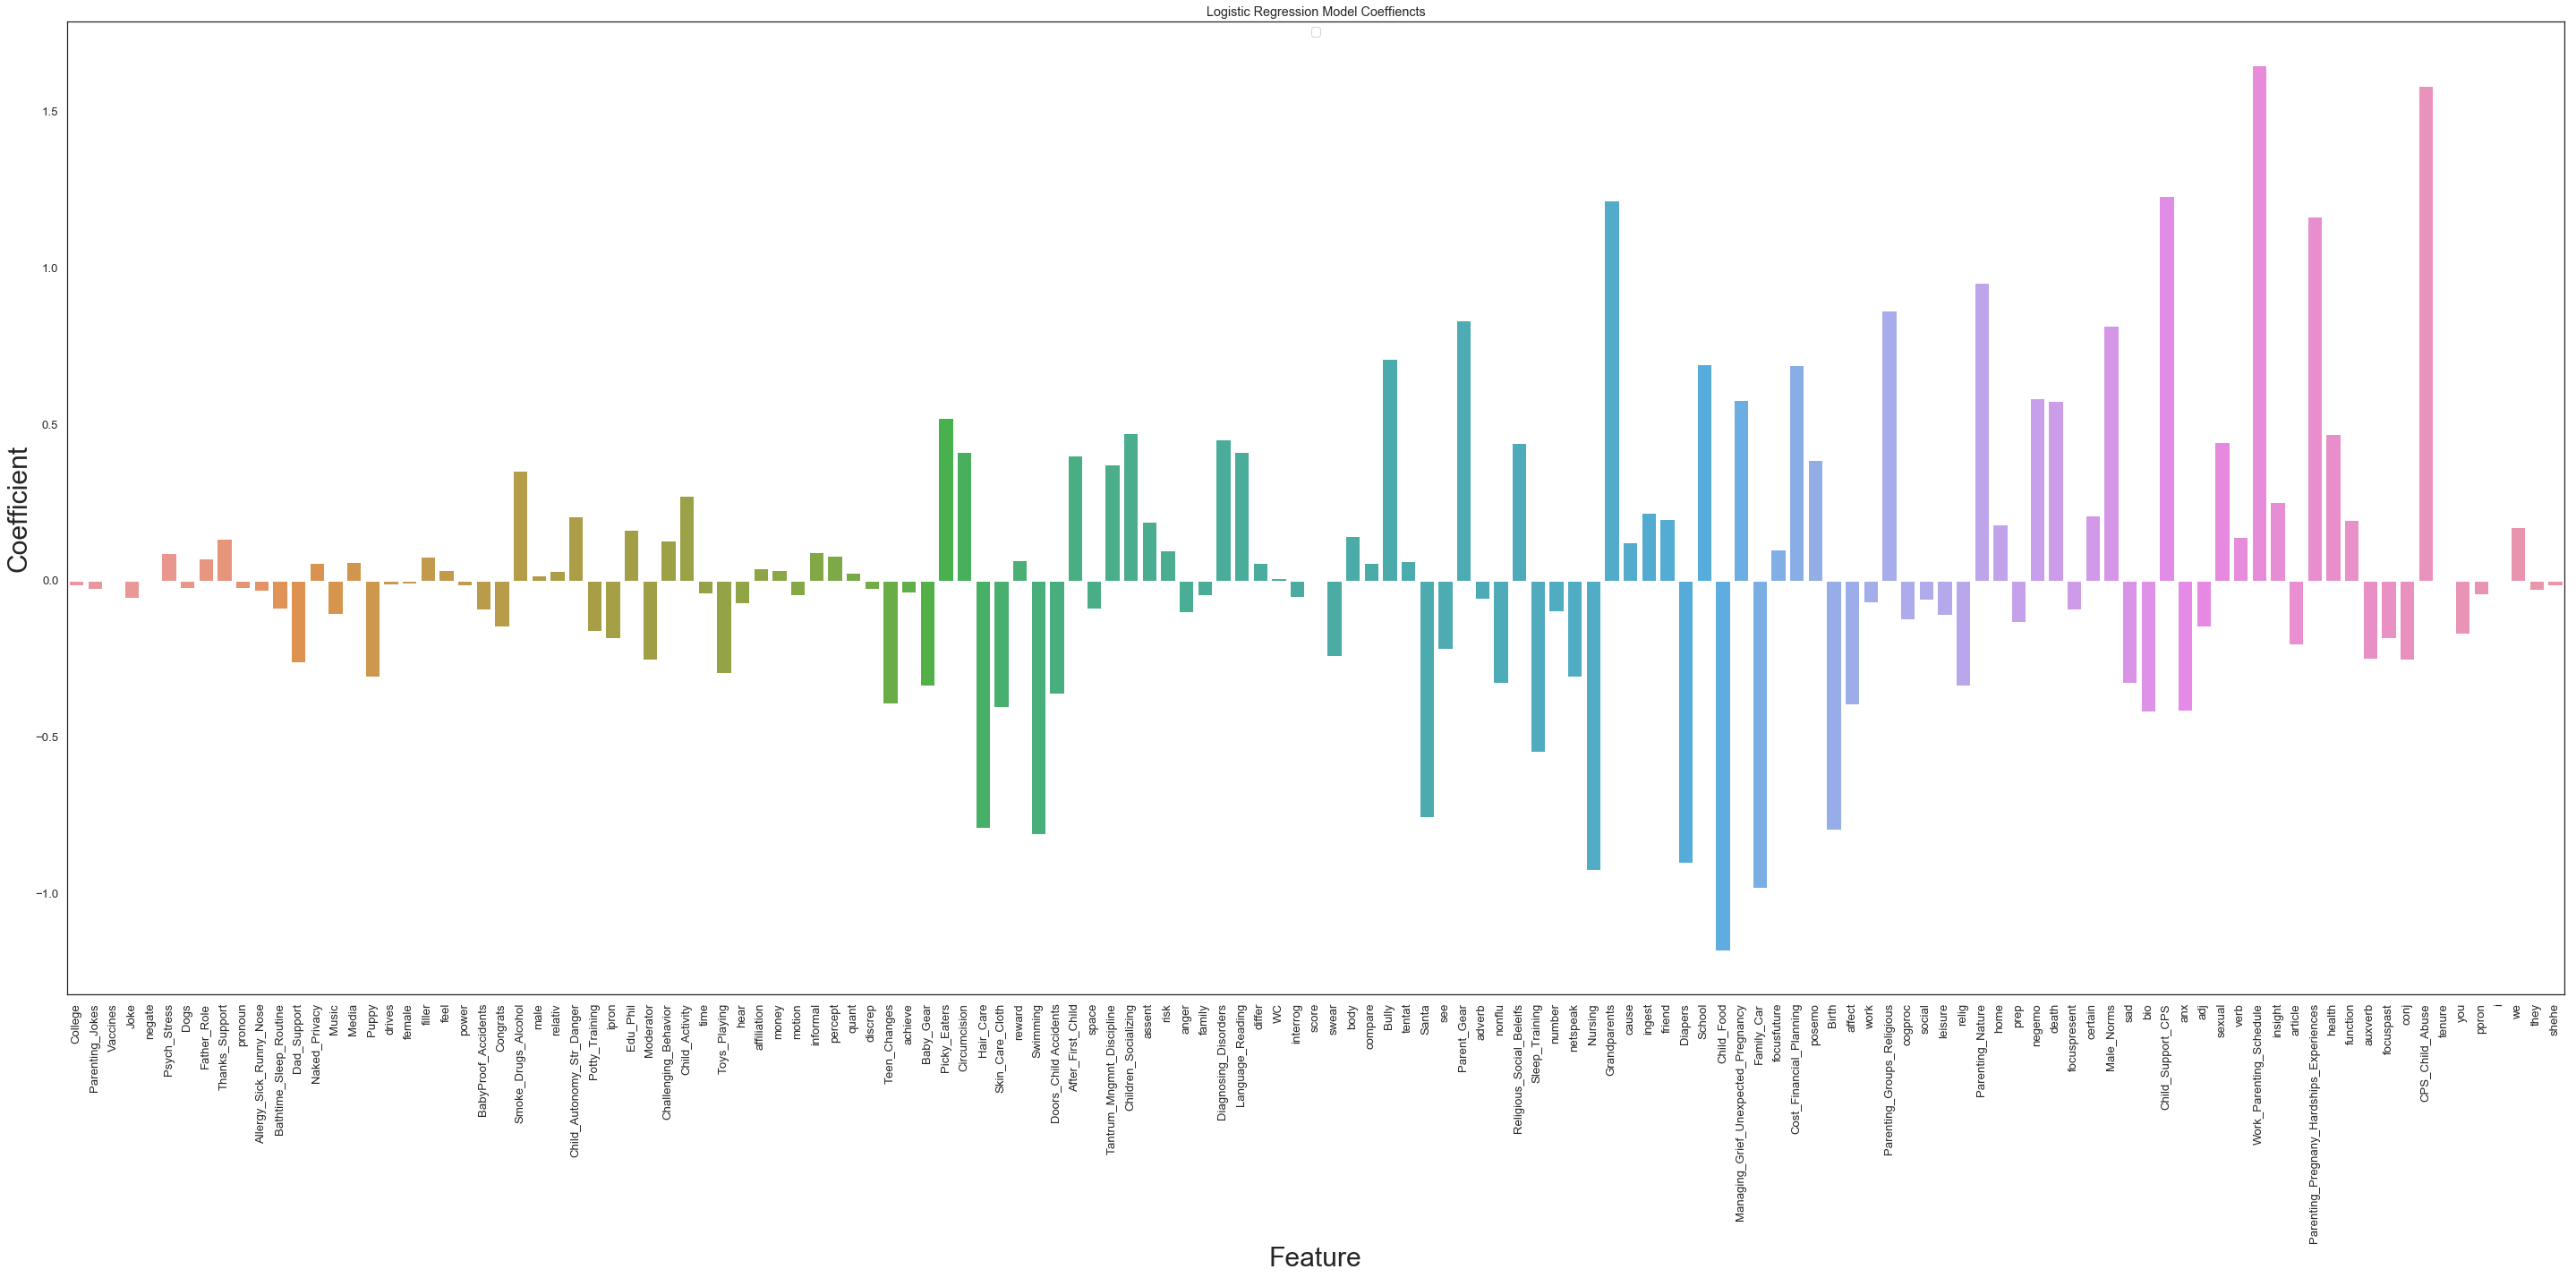

In [176]:
LDAplusthrlogmodel, LDAplusthrlogpredict, p_values = logreg_model(X_train_res=X_train_res, y_train_res=y_train_res, X_test=X_test_res, y_test=y_test, Features=All_Features)

In [177]:
logreg_sorted_random = LDAplusthrlogpredict.sort_values(by=['p-values'], ascending=[True])

In [178]:
logreg_sorted_random['p-values'] = logreg_sorted_random['p-values'].round(3)
logreg_sorted_random['OR'] = logreg_sorted_random['OR'].round(3)
logreg_sorted_random['importance'] = logreg_sorted_random['importance'].round(3)

In [179]:
logreg_sorted_random.to_csv('logreg_sorted_random.csv')

In [180]:
logreg_sorted_random

,predictor,importance,p-values,OR,up,low
0,tenure,-0.002,0.000,0.998,-0.002146,-0.002244
65,CPS_Child_Abuse,1.581,0.000,4.860,1.718691,1.443504
1,conj,-0.252,0.000,0.777,-0.229539,-0.275119
2,focuspast,-0.183,0.001,0.833,-0.164101,-0.202462
3,auxverb,-0.251,0.002,0.778,-0.221791,-0.279374
4,function,0.194,0.007,1.214,0.218725,0.169051
5,health,0.467,0.011,1.595,0.524610,0.409678
66,Parenting_Pregnany_Hardships_Experiences,1.165,0.011,3.205,1.346459,0.983132
6,article,-0.206,0.011,0.814,-0.177106,-0.234259
7,insight,0.251,0.011,1.285,0.285018,0.217120


# Cross Validation

In [49]:
rus = RandomUnderSampler(random_state=0)  
X, Y = rus.fit_sample(Mizo_All_pivoted[All_Features], Mizo_All_pivoted['Throwaway'])

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision', 'recall', 'f1']
clf = LogisticRegression()
scores = cross_validate(clf, X, Y, cv=10, scoring=scoring)

In [51]:
scores

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_precision'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_recall'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarni

{'fit_time': array([ 0.22975588,  0.17530322,  0.21103692,  0.1449461 ,  0.17455792,
         0.15910506,  0.15485096,  0.14679098,  0.20914578,  0.17295885]),
 'score_time': array([ 0.00176001,  0.00166893,  0.00188923,  0.00169086,  0.00171804,
         0.00166488,  0.00166225,  0.0015502 ,  0.00190997,  0.00169325]),
 'test_accuracy': array([ 0.71575342,  0.72945205,  0.68150685,  0.7260274 ,  0.69520548,
         0.79109589,  0.72260274,  0.70890411,  0.67465753,  0.7137931 ]),
 'train_accuracy': array([ 0.75323686,  0.75057121,  0.75704494,  0.75285605,  0.75476009,
         0.74828637,  0.74866717,  0.75361767,  0.75780655,  0.75951294]),
 'test_precision': array([ 0.71724138,  0.76377953,  0.70866142,  0.72297297,  0.71111111,
         0.81954887,  0.70440252,  0.69677419,  0.67346939,  0.73134328]),
 'train_precision': array([ 0.75996873,  0.75425039,  0.76223776,  0.75736434,  0.7587007 ,
         0.75232198,  0.75251353,  0.76386688,  0.76674547,  0.7651633 ]),
 'test_recall'

In [53]:
scores['train_accuracy'].mean()

0.75363598530559062

In [52]:
scores['test_accuracy'].mean()

0.715899858290033

In [54]:
scores['train_precision'].mean()

0.75931330710742695

In [55]:
scores['test_precision'].mean()

0.72493046610656175

In [56]:
scores['train_recall'].mean()

0.74274570765822623

In [57]:
scores['test_recall'].mean()

0.69909305621162021

In [58]:
scores['train_f1'].mean()

0.75092547693557754

In [59]:
scores['test_f1'].mean()

0.7107578268841469

# Score_Comment

In [79]:
Mizo_All_Pivot_numComments.head()

,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,tenure,they,time,verb,we,work,you,num_comments,score_comment
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
----------FTFY,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.406521,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.090138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.343455,0.000000,0.132916,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,100.0,0.0,2.0,1.50,6.0,5.0,1.00,1.5,0.0,4.0,0.0,7.00,1.5,0.5,1.50,1.0,8.0,0.00,6.0,0.0,1.50,0.0,5.00,0.50,1.0,0.5,0.0,0.0,10.0,8.50,0.0,47.00,1.0,3.0,0.00,5.50,5.0,0.0,3.0,1.0,6.0,1.0,0.5,1.50,1.0,1.0,3.50,5.0,0.0,1.00,4.50,1.00,1.00,10.0,11.5,16.0,1.0,9.0,0.0,1.00,1.0,0.50,11.00,0.50,0.0,1.0,14.50,3.5,0.0,1.5,0,1.0,3.50,15.5,0.0,4.0,2.50,2,5.5000
------me,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.802698,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,10.0,0.0,0.0,0.00,1.0,0.0,0.00,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,3.0,0.00,0.0,0.0,0.00,1.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6.00,0.0,0.0,0.00,1.00,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,1.0,1.0,3.0,1.0,1.0,0.0,0.00,0.0,0.00,2.00,0.00,0.0,0.0,0.00,0.0,0.0,1.0,0,0.0,1.00,1.0,0.0,0.0,0.00,1,2.0000
-----iMartijn-----,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.647002,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.0,29.0,0.0,0.0,1.00,5.0,1.0,0.00,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,2.0,1.00,3.0,0.0,0.00,0.0,1.00,2.00,0.0,1.0,0.0,0.0,0.0,3.00,0.0,14.00,0.0,0.0,0.00,1.00,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.00,1.0,1.0,0.00,0.0,0.0,0.00,0.00,1.00,1.00,2.0,3.0,4.0,1.0,4.0,0.0,0.00,0.0,0.00,7.00,0.00,0.0,0.0,5.00,1.0,0.0,1.0,0,1.0,2.00,3.0,0.0,0.0,0.00,1,7.0000
-----username-----,0.0,0.0,0.093582,0.000000,0.0,0.191683,0.0,0.0,0.0,0.0,0.0,0.000000,0.154482,0.0,0.05022,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.048615,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.068531,0.0,0.0,0.0,0.0,0.0,0,0.314393,0.0,31.0,0.0,0.5,2.25,1.5,1.0,1.25,0.0,0.0,2.0,0.0,1.25,0.5,0.0,1.25,0.5,3.0,0.75,3.0,0.0,0.75,0.0,2.75,1.25,0.0

In [80]:
X_train, X_test, y_train, y_test = train_test_split(Mizo_All_Pivot_numComments[All_Features], Mizo_All_Pivot_numComments['Throwaway'], test_size=0.20, random_state=42)

In [81]:
rus = RandomUnderSampler(random_state=0)  
X_res, y_res = rus.fit_sample(X_train, y_train)
X_train_res, y_train_res, = X_res, y_res

In [82]:
rus = RandomUnderSampler(random_state=0)  
X_test, y_test = rus.fit_sample(X_test, y_test)
X_test_res, y_test_res, = X_test, y_test

0.723974763407
(0.72187500000000004, 0.72870662460567825, 0.72527472527472514, None)
AUC value is
0.798057498831


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt


[('tenure', -0.0023218354303141419, 3.8956846969242946e-22, 0.9976808579446409, -0.0022719100334490498, -0.0023717608271792341), ('conj', -0.24125857334269568, 0.00023352748344689905, 0.78563845496067053, -0.21831273586933686, -0.2642044108160545), ('focuspast', -0.17811280597570092, 0.0018391650838787024, 0.83684801670700559, -0.15881156592204679, -0.19741404602935506), ('auxverb', -0.24331099904898124, 0.0029371952676795873, 0.78402764400022951, -0.21435644553636854, -0.2722655525615939), ('score', 0.026726850486217802, 0.0080791461261756799, 1.0270872160704929, 0.029805448879562803, 0.023648252092872801), ('health', 0.47362475005021248, 0.0095621315543352389, 1.6058042959732062, 0.5314015181667846, 0.41584798193364031), ('verb', 0.1424922730142574, 0.010120865894451032, 1.1531441705943792, 0.16176435644254999, 0.12322018958596483), ('insight', 0.25242932562453069, 0.010736965682727188, 1.2871485245220444, 0.28657346037770159, 0.21828519087135981), ('function', 0.17966142699953228, 0

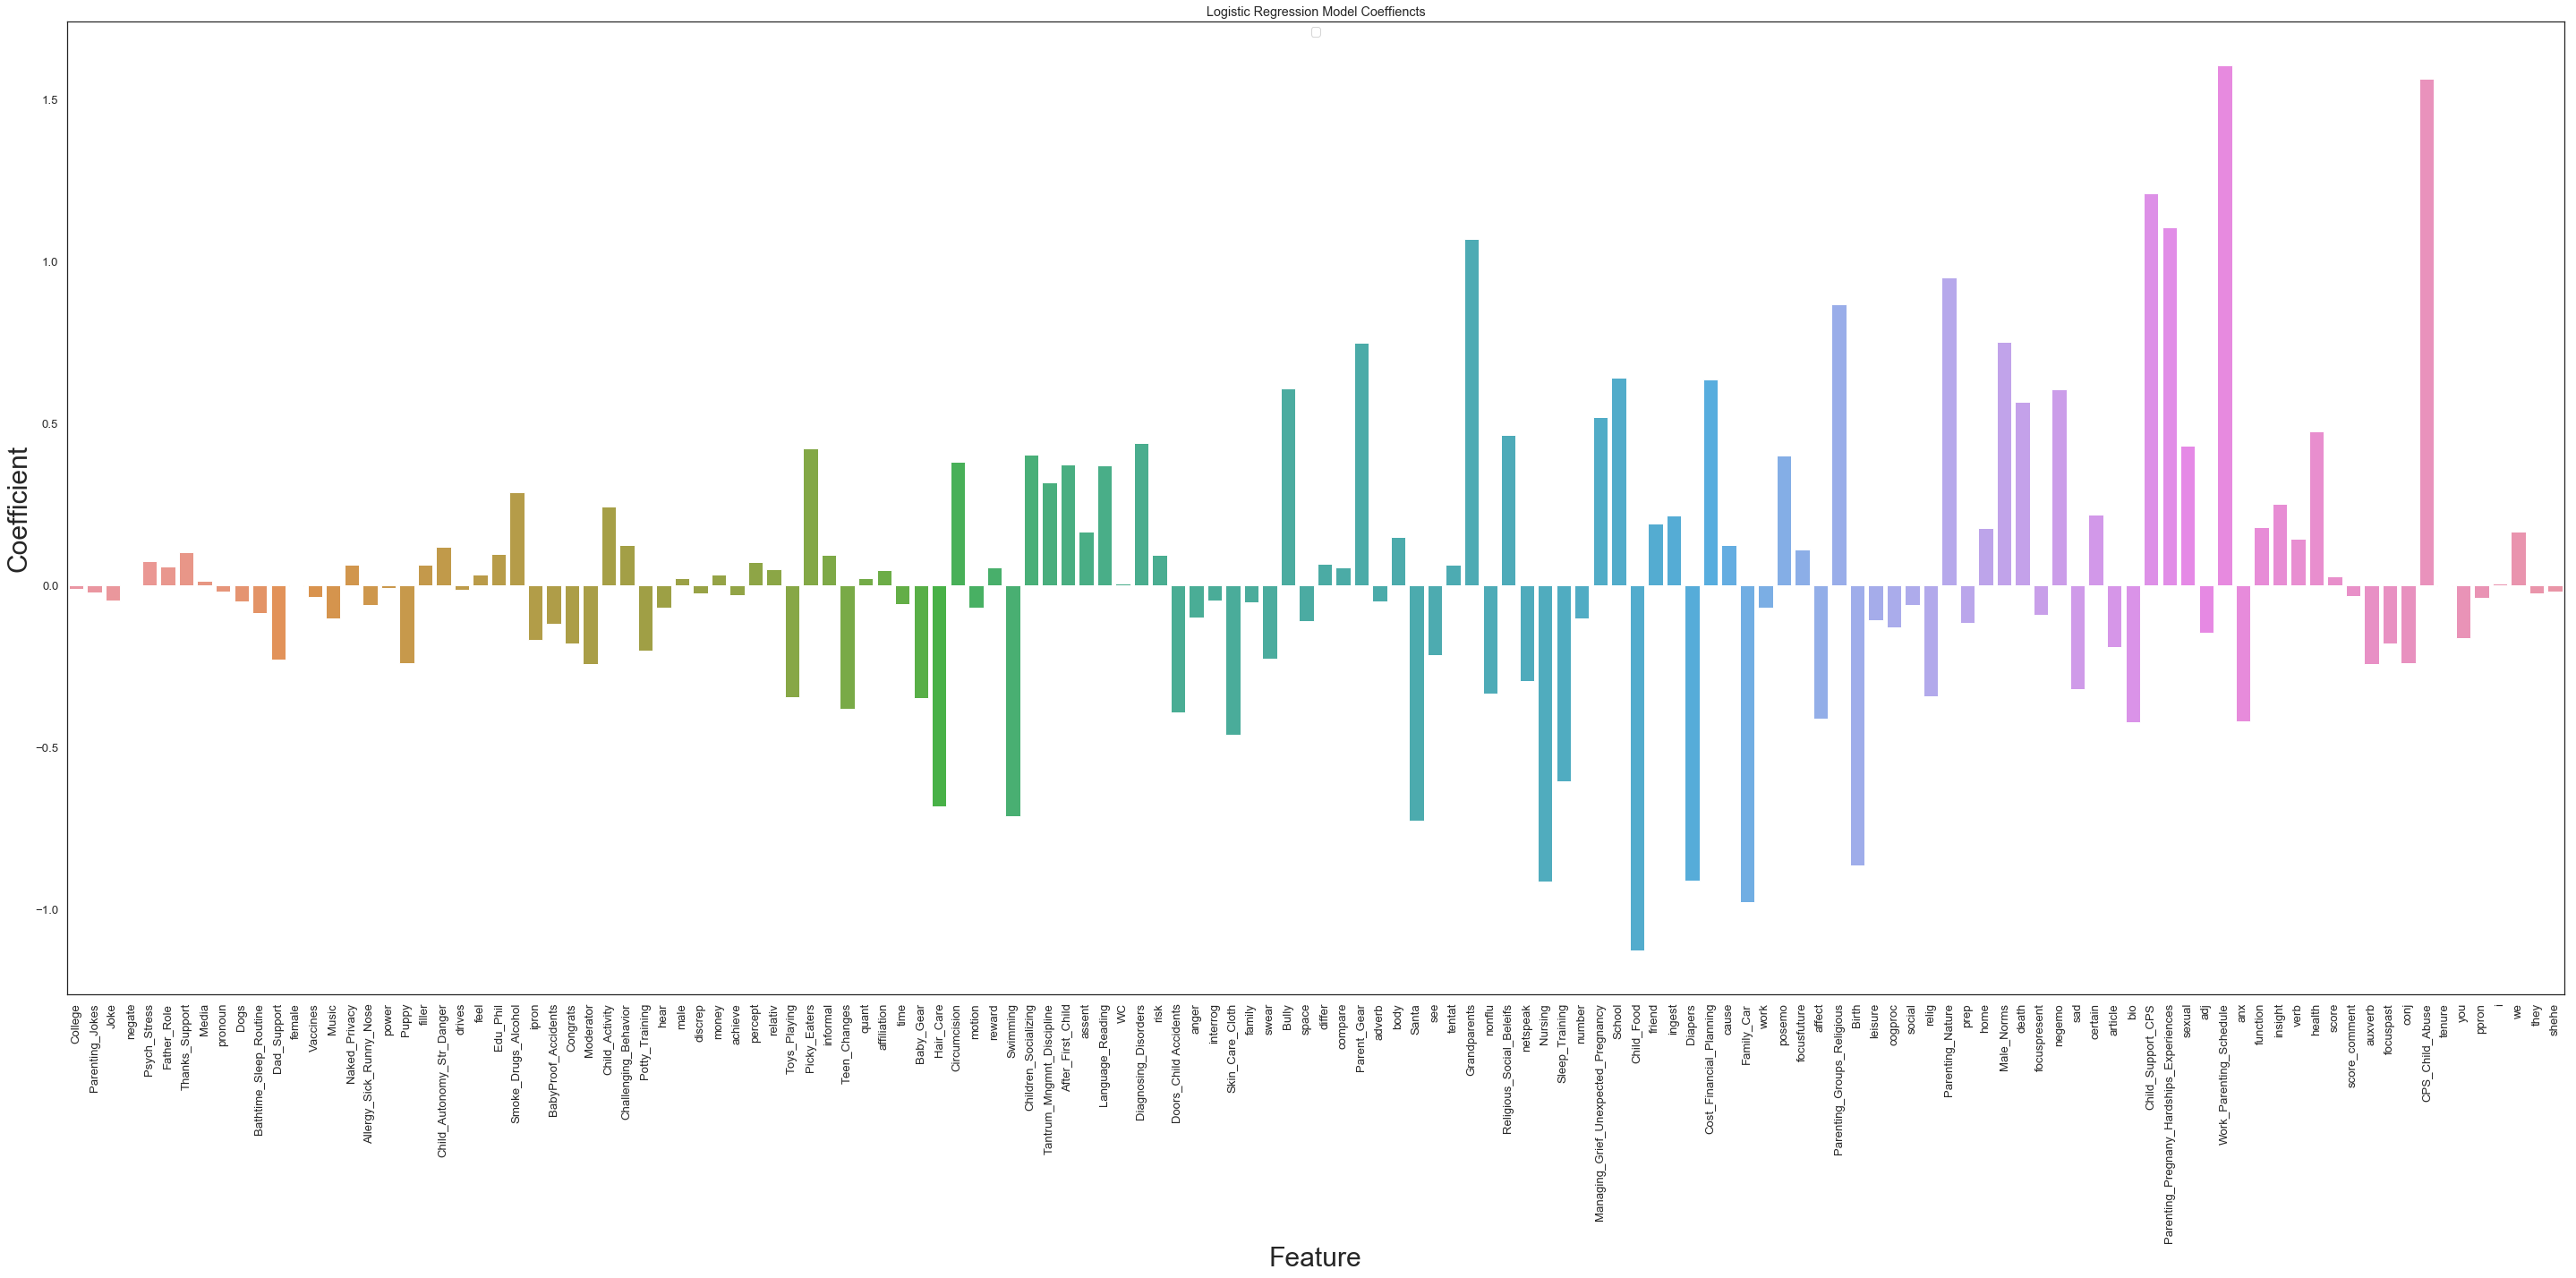

In [83]:
LDAplusthrlogmodel, LDAplusthrlogpredict, p_values = logreg_model(X_train_res=X_train_res, y_train_res=y_train_res, X_test=X_test_res, y_test=y_test, Features=All_Features)

# Time + Score

In [106]:
Mizo_All_numComments_score_sum = pd.merge(Mizo_All, Mizo_Sum, on="author")

In [108]:
start_date = pd.datetime(2012,1,1)
split_date = pd.datetime(2018,1,1)

df_training_before, df_test_before = setting_training_test(Mizo_All, startdate=start_date, splitdate=split_date )

In [109]:
df_training_before

,Throwaway,author,created_utc,score,WC,adverb,relativ,focuspresent,time,function,you,social,ppron,pronoun,verb,i,space,prep,affiliation,we,drives,home,article,bio,body,motion,number,percept,adj,see,money,death,power,work,ipron,informal,assent,interrog,auxverb,cause,cogproc,tentat,compare,quant,affect,posemo,leisure,conj,differ,negate,insight,they,focusfuture,reward,focuspast,negemo,health,achieve,feel,family,female,sad,risk,shehe,male,discrep,certain,hear,nonflu,netspeak,anx,ingest,friend,filler,anger,sexual,swear,relig,name,link_id,parent_id,Picky_Eaters,Sleep_Training,Nursing,Dad_Support,Parenting_Jokes,Smoke_Drugs_Alcohol,College,Grandparents,Naked_Privacy,Allergy_Sick_Runny_Nose,Child_Food,Parenting_Groups_Religious,Father_Role,Toys_Playing,Diapers,After_First_Child,Child_Activity,Baby_Gear,Psych_Stress,Parent_Gear,Child_Autonomy_Str_Danger,Circumcision,Hair_Care,Vaccines,Teen_Changes,BabyProof_Accidents,Swimming,Moderator,School,Male_Norms,Birth,Joke,Dogs,Diagnosing_Disorders,Cost_Financial_Planning,Children_Socializing,Santa,Work_Parenting_Schedule,Religious_Social_Beleifs,CPS_Child_Abuse,Bathtime_Sleep_Routine,Media,Tantrum_Mngmnt_Discipline,Puppy,Parenting_Pregnany_Hardships_Experiences,Potty_Training,Language_Reading,Music,Edu_Phil,Congrats,Challenging_Behavior,Managing_Grief_Unexpected_Pregnancy,Doors_Child Accidents,Family_Car,Bully,Thanks_Support,Parenting_Nature,Skin_Care_Cloth,Child_Support_CPS
131855,0,nobodybelievesyou,2012-01-01 00:00:17,1,9.0,0.0,0.0,2.0,0.0,5.0,0.0,2.0,3.0,4.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_c3ctzvm,t3_ny1ud,t3_ny1ud,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131856,0,tenshikitsune,2012-01-01 00:08:01,1,63.0,4.0,7.0,2.0,3.0,32.0,1.0,3.0,2.0,6.0,4.0,0.0,4.0,7.0,1.0,1.0,3.0,1.0,6.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,4.0,1.0,0.0,1.0,4.0,1.0,3.0,2.0,0.0,2.0,3.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,t1_c3cu223,t3_nvf7c,t1_c3cj6dq,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.970081,0.000000
131857,0,bloody_hell,2012-01-01 00:10:17,6,13.0,1.0,1.0,0.0,1.0,9.0,0.0,2.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,t1_c3cu2o7,t3_nxipd,t1_c3ct1cw,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.753461,0.000000,0.000000,0.000000,

In [149]:
df_training = prepare_data_for_models(df_training_before)
df_test = prepare_data_for_models(df_test_before)

In [150]:
tenure = calculate_tenure(Mizo_All)

In [151]:
df_training = pd.merge(df_training, tenure, on="author")
df_test = pd.merge(df_test, tenure, on="author")

In [152]:
df_training = pd.merge(df_training, Mizo_Sum, on="author")
df_test = pd.merge(df_test, Mizo_Sum, on="author")

In [153]:
df_training =  df_training.fillna(0)
df_test =  df_test.fillna(0)

In [154]:
df_training['score_comments'] = df_training['score']/df_training['num_comments']
df_test['score_comments'] = df_test['score']/df_test['num_comments']

In [155]:
df_training

,author,After_First_Child,Allergy_Sick_Runny_Nose,BabyProof_Accidents,Baby_Gear,Bathtime_Sleep_Routine,Birth,Bully,CPS_Child_Abuse,Challenging_Behavior,Child_Activity,Child_Autonomy_Str_Danger,Child_Food,Child_Support_CPS,Children_Socializing,Circumcision,College,Congrats,Cost_Financial_Planning,Dad_Support,Diagnosing_Disorders,Diapers,Dogs,Doors_Child Accidents,Edu_Phil,Family_Car,Father_Role,Grandparents,Hair_Care,Joke,Language_Reading,Male_Norms,Managing_Grief_Unexpected_Pregnancy,Media,Moderator,Music,Naked_Privacy,Nursing,Parent_Gear,Parenting_Groups_Religious,Parenting_Jokes,Parenting_Nature,Parenting_Pregnany_Hardships_Experiences,Picky_Eaters,Potty_Training,Psych_Stress,Puppy,Religious_Social_Beleifs,Santa,School,Skin_Care_Cloth,Sleep_Training,Smoke_Drugs_Alcohol,Swimming,Tantrum_Mngmnt_Discipline,Teen_Changes,Thanks_Support,Throwaway,Toys_Playing,Vaccines,WC,Work_Parenting_Schedule,achieve,adj,adverb,affect,affiliation,anger,anx,article,assent,auxverb,bio,body,cause,certain,cogproc,compare,conj,death,differ,discrep,drives,family,feel,female,filler,focusfuture,focuspast,focuspresent,friend,function,health,hear,home,i,informal,ingest,insight,interrog,ipron,leisure,male,money,motion,negate,negemo,netspeak,nonflu,number,percept,posemo,power,ppron,prep,pronoun,quant,relativ,relig,reward,risk,sad,score,see,sexual,shehe,social,space,swear,tentat,they,time,verb,we,work,you,created_utcmin,created_utcmax,tenure,num_comments,score_comments
0,----------FTFY,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.406521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.343455,0.000000,0.132916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,100.000000,0.000000,2.000000,1.500000,6.000000,5.000000,1.000000,1.500000,0.000000,4.000000,0.000000,7.000000,1.500000,0.500000,1.500000,1.000000,8.000000,0.000000,6.000000,0.000000,1.500000,0.000000,5.000000,0.500000,1.000000,0.500000,0.000000,0.000000,10.000000,8.500000,0.000000,47.000000,1.000000,3.000000,0.000000,5.500000,5.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.500000,1.500000,1.000000,1.000000,3.500000,5.000000,0.000000,1.000000,4.500000,1.000000,1.000000,10.000000,11.500000,16.000000,1.000000,9.000000,0.000000,1.000000,1.000000,0.500000,11.000000,0.500000,0.000000,1.000000,14.500000,3.500000,0.000000,1.500000,1.000000,3.500000,15.500000,0.000000,4.000000,2.500000,2015-12-12 04:52:56,2015-12-12 21:14:02,0,2,5.500000
1,----_____----,0.000000,0.000000,0.000000,0.192439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.417825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267060,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000,21.000000,0.000000,0.000000,0.500000,1.000000,2.500000,1.000000,0.000000,0.000000,0.500000,0.000000,2.000000,0.500000,0.000000,0.500000,0.000000,1.000000,0.500000,2.000000,0.000000,0.000000,0.000000,2.000000,0.500000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,2.500000,0.000000,2.500000,2.500000,3.500000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,27.000000,0.500000,0.000000,0.500000,3.500000,0.000000,0.000000,0.500000,0.000000,1.000000,3.500000,0.500000,0.000000,1.000000,2017-07-13 00:36:15,201

In [156]:
X_train_res, y_train_res =  balance_dataset(df_training, Features=All_Features, y_value='Throwaway')
X_test,  y_test = balance_dataset(df_test, Features=All_Features , y_value='Throwaway')

In [157]:
X_train_res, X_test_res = Normalize_Dataset(X_train_res,X_test)

In [158]:
X_train_res

array([[-0.39697409, -0.43687219, -0.10862811, ..., -0.19310818,
        -0.30388791, -0.23849553],
       [-0.16131571, -0.43687219, -0.68712745, ..., -0.19310818,
        -0.30388791,  0.07010321],
       [-0.34910598, -0.21775951,  0.26137042, ..., -0.19310818,
         0.29797567, -0.23868099],
       ..., 
       [-0.33805949, -0.43687219, -0.21468633, ..., -0.19310818,
        -0.30388791, -0.14354207],
       [-0.33805949, -0.43687219, -0.62927752, ..., -0.19310818,
        -0.30388791, -0.14354207],
       [-0.42643138, -0.43687219, -0.41716109, ..., -0.19310818,
        -0.30388791, -0.25036471]])

0.699101796407
(0.6831955922865014, 0.74251497005988021, 0.71162123385939757, None)
AUC value is
0.776946107784
[('tenure', -1.0449547414412077, 4.3459012880437961e-27, 0.3517077368031481, -1.0241688808592733, -1.0657406020231421), ('Male_Norms', 0.29712509932902242, 4.2236401441333524e-05, 1.3459836705703843, 0.32376321790256585, 0.270486980755479), ('CPS_Child_Abuse', 0.33436859564322641, 4.515614468566653e-05, 1.3970579981735565, 0.36410202486031618, 0.30463516642613664), ('Parenting_Pregnany_Hardships_Experiences', 0.27040470426584723, 0.00016165217070458754, 1.3104947062256598, 0.29717853252958859, 0.24363087600210584), ('Work_Parenting_Schedule', 0.21282771419058094, 0.00042338851435211328, 1.2371714857906171, 0.23617118066847553, 0.18948424771268635), ('Parenting_Nature', 0.20965942797592199, 0.00094439615878367828, 1.233257975261411, 0.23390688535619422, 0.18541197059564976), ('relig', -0.26401243350234888, 0.0010065406866358972, 0.76796399111525804, -0.24003512740340155, -0.28

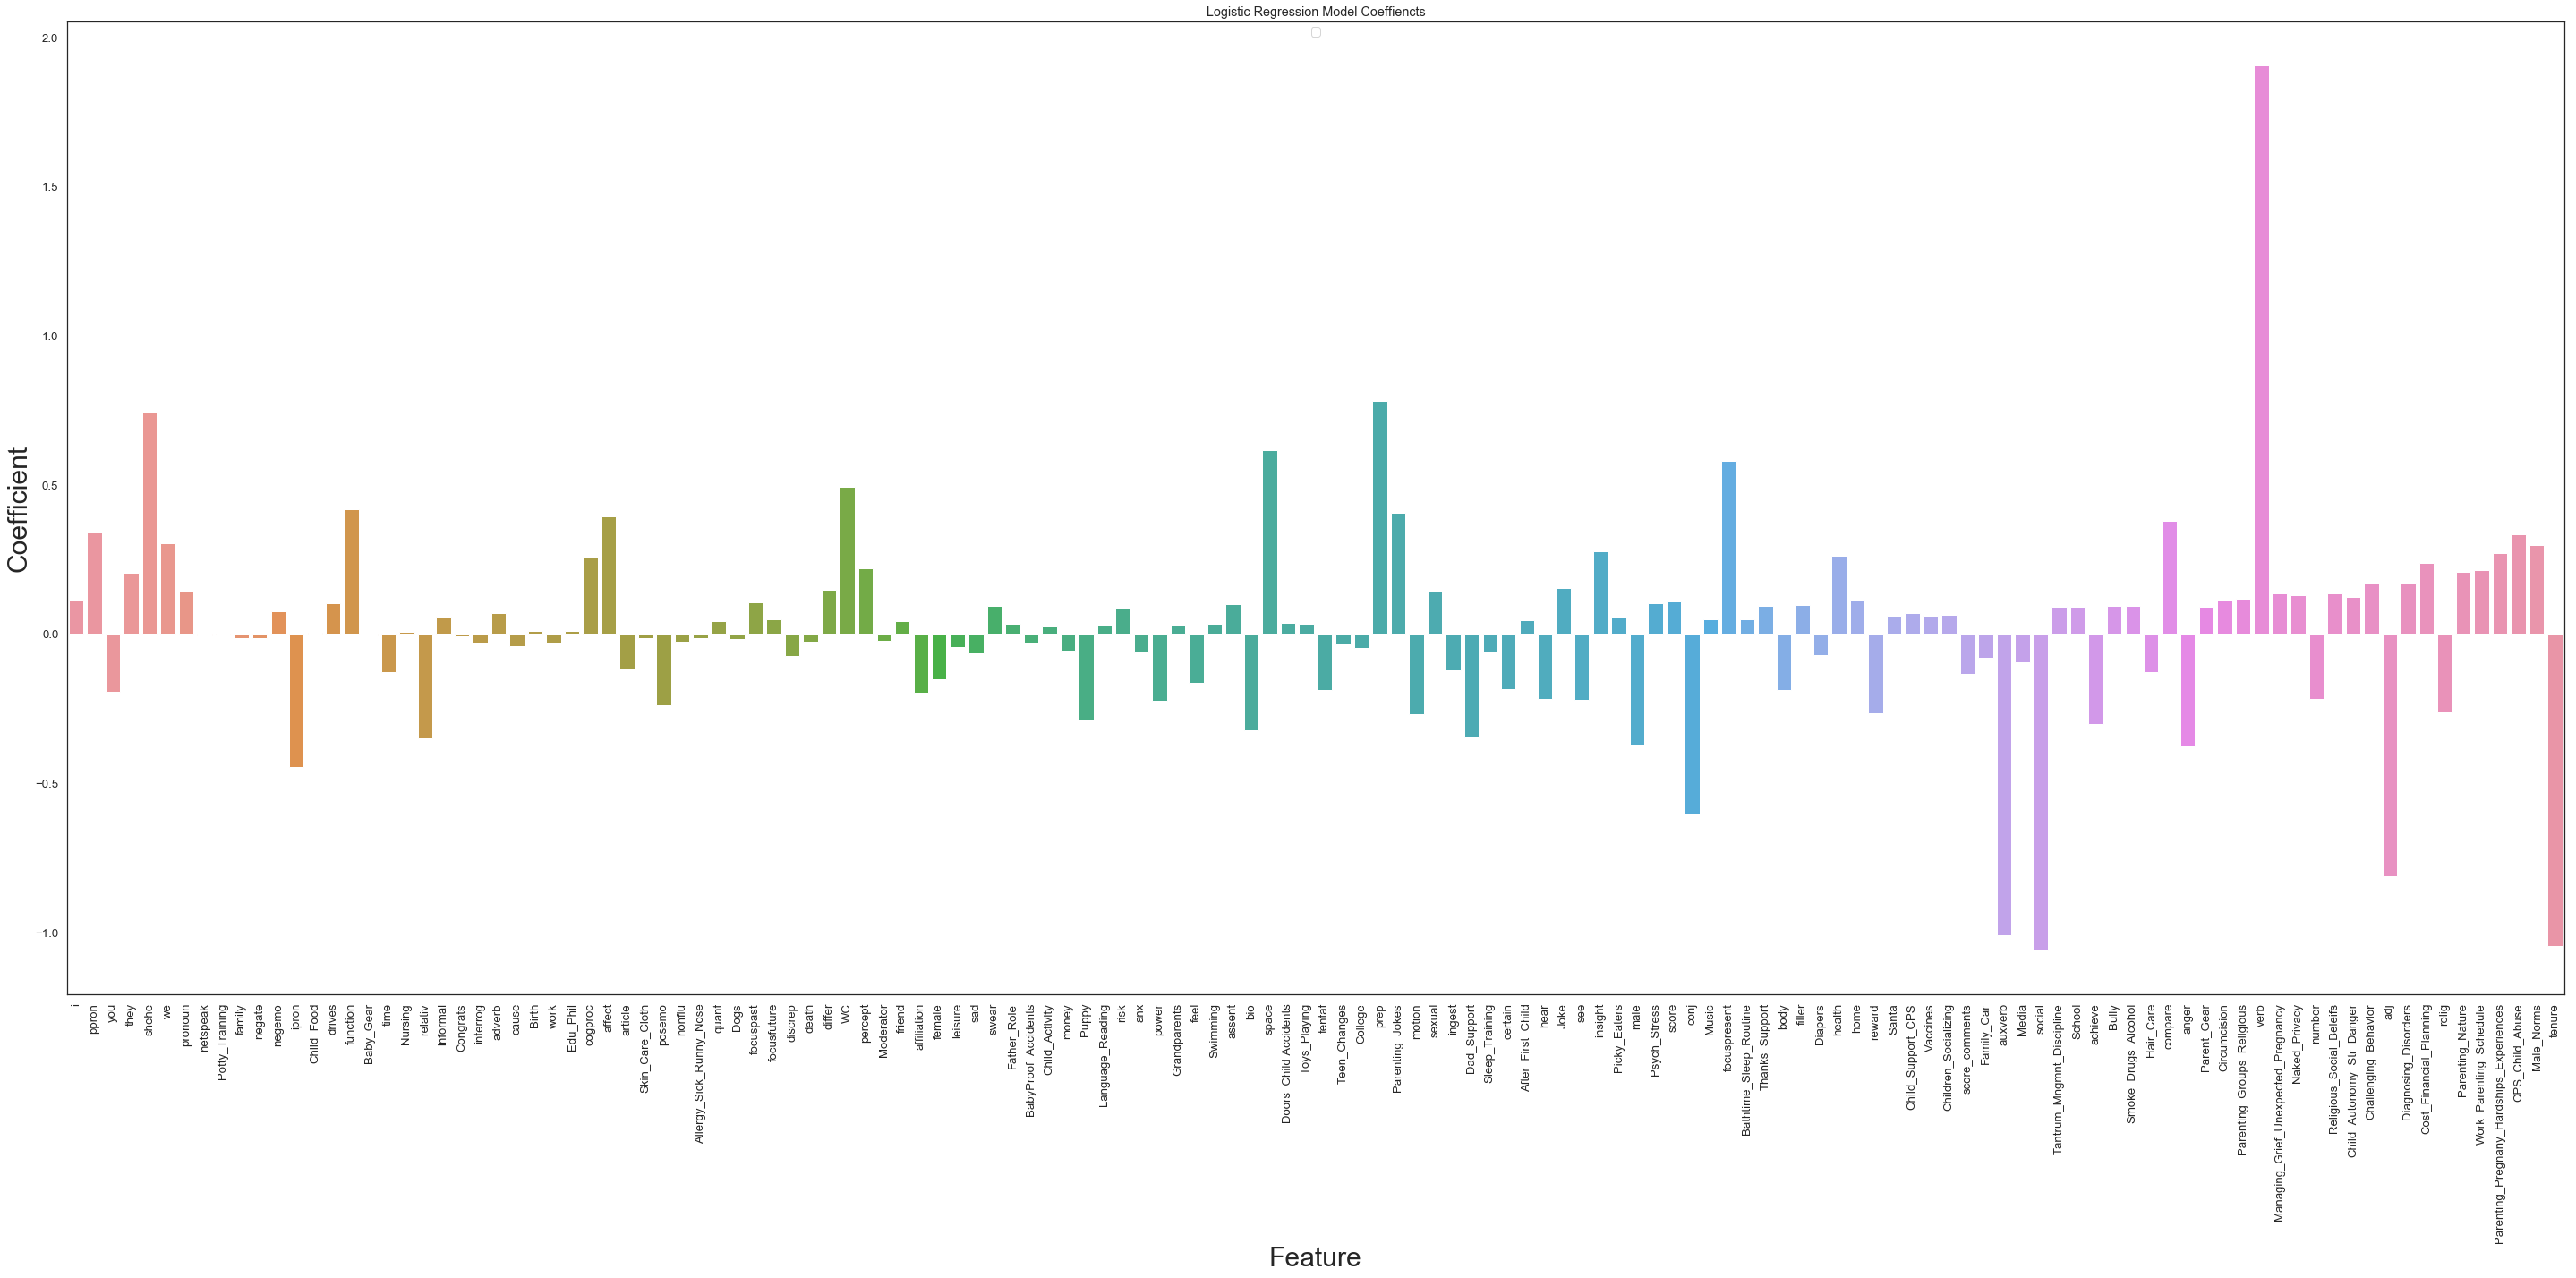

In [159]:
LDAplusthrlogmodel, LDAplusthrlogpredict, p_values = logreg_model(X_train_res=X_train_res, y_train_res=y_train_res, X_test=X_test_res, y_test=y_test, Features=All_Features)

In [160]:
logreg_sorted_random = LDAplusthrlogpredict.sort_values(by=['p-values'], ascending=[True])

In [161]:
logreg_sorted_random['p-values'] = logreg_sorted_random['p-values'].round(3)
logreg_sorted_random['OR'] = logreg_sorted_random['OR'].round(3)
logreg_sorted_random['importance'] = logreg_sorted_random['importance'].round(3)

In [2]:
logreg_sorted_random.to_csv('logreg_sorted_score_comments.csv')

NameError: name 'logreg_sorted_random' is not defined

In [163]:
logreg_sorted_random

,predictor,importance,p-values,OR,up,low
0,tenure,-1.045,0.000,0.352,-1.024169,-1.065741
1,Male_Norms,0.297,0.000,1.346,0.323763,0.270487
2,CPS_Child_Abuse,0.334,0.000,1.397,0.364102,0.304635
3,Parenting_Pregnany_Hardships_Experiences,0.270,0.000,1.310,0.297179,0.243631
4,Work_Parenting_Schedule,0.213,0.000,1.237,0.236171,0.189484
5,Parenting_Nature,0.210,0.001,1.233,0.233907,0.185412
6,relig,-0.264,0.001,0.768,-0.240035,-0.287990
7,Cost_Financial_Planning,0.238,0.002,1.269,0.265496,0.210546
8,Diagnosing_Disorders,0.171,0.004,1.186,0.193693,0.148175
9,adj,-0.812,0.005,0.444,-0.717837,-0.906342
